In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import time


In [2]:
def poisson_2d(N):
    """
    Discretizes the 2D Poisson equation on a unit square with Dirichlet boundary conditions.
    
    Parameters:
    N (int): Number of interior points in one dimension (total unknowns = N^2).
    
    Returns:
    A (scipy.sparse.csr_matrix): Sparse matrix representing the Laplacian.
    b (numpy.ndarray): Right-hand side vector.
    """
    h = 1.0 / (N + 1)
    # 1D Laplacian
    T = sp.diags([ -1 * np.ones(N-1), 2 * np.ones(N), -1 * np.ones(N-1)], [-1,0,1], format='csr')
    I = sp.eye(N, format='csr')
    # 2D Laplacian using Kronecker products
    A = sp.kron(I, T) + sp.kron(T, I)
    A /= h**2
    
    # Right-hand side (f = 1 for simplicity)
    b = np.ones(N*N)
    
    return A, b


In [3]:
class MultilevelAdditiveSchwarz:
    def __init__(self, A, N, num_subdomains_per_dim=4, overlap=1):
        """
        Initializes the Multilevel Additive Schwarz preconditioner.
        
        Parameters:
        A (scipy.sparse.csr_matrix): Global sparse matrix.
        N (int): Number of interior points in one dimension.
        num_subdomains_per_dim (int): Number of subdomains along each dimension.
        overlap (int): Number of overlapping grid points.
        """
        self.A = A
        self.N = N
        self.num_subdomains_per_dim = num_subdomains_per_dim
        self.overlap = overlap
        self.subdomains = []
        self.levels = []
        
        # Create Level 1 (Fine Level) Subdomains
        self.levels.append(self.create_subdomains(self.num_subdomains_per_dim, self.overlap))
        
        # Create Level 2 (Coarse Level) Subdomains by aggregating fine subdomains
        num_coarse_subdomains_per_dim = max(1, self.num_subdomains_per_dim // 2)
        self.levels.append(self.create_subdomains(num_coarse_subdomains_per_dim, self.overlap*2))
        
        # Precompute local solvers for each subdomain at each level
        self.local_solvers = []
        for level in self.levels:
            level_solvers = []
            for indices in level:
                A_sub = A[indices,:][:,indices].tocsc()
                # Perform sparse LU decomposition
                solver = spla.splu(A_sub)
                level_solvers.append((indices, solver))
            self.local_solvers.append(level_solvers)
    
    def create_subdomains(self, num_subdomains_per_dim, overlap):
        """
        Creates overlapping subdomains.
        
        Parameters:
        num_subdomains_per_dim (int): Number of subdomains along each dimension.
        overlap (int): Number of overlapping grid points.
        
        Returns:
        subdomains (list of numpy.ndarray): List containing indices for each subdomain.
        """
        N = self.N
        step = N // num_subdomains_per_dim
        subdomains = []
        for i in range(num_subdomains_per_dim):
            for j in range(num_subdomains_per_dim):
                # Define the range with overlap
                row_start = max(i*step - overlap, 0)
                row_end = min((i+1)*step + overlap, N)
                col_start = max(j*step - overlap, 0)
                col_end = min((j+1)*step + overlap, N)
                
                # Get grid indices for this subdomain
                indices = []
                for row in range(row_start, row_end):
                    for col in range(col_start, col_end):
                        index = row * N + col
                        indices.append(index)
                subdomains.append(np.array(indices))
        return subdomains
    
    def apply(self, v):
        """
        Applies the MAS preconditioner to vector v.
        
        Parameters:
        v (numpy.ndarray): Input vector.
        
        Returns:
        z (numpy.ndarray): Preconditioned vector.
        """
        z = np.zeros_like(v)
        # Iterate over levels
        for level_solvers in self.local_solvers:
            # Iterate over subdomains in the current level
            for indices, solver in level_solvers:
                v_sub = v[indices]
                # Solve A_sub z_sub = v_sub
                z_sub = solver.solve(v_sub)
                # Accumulate the corrections
                z[indices] += z_sub
        return z


In [4]:
def jacobi_preconditioner(A):
    """
    Creates a Jacobi preconditioner (diagonal scaling) for matrix A.
    
    Parameters:
    A (scipy.sparse.csr_matrix): Sparse matrix.
    
    Returns:
    M_inv (scipy.sparse.linalg.LinearOperator): Jacobi preconditioner operator.
    """
    # Extract the diagonal of A
    diagonal = A.diagonal()
    # Avoid division by zero
    diagonal[diagonal == 0] = 1.0
    # Define the preconditioner function
    def matvec(v):
        return v / diagonal
    M_inv = spla.LinearOperator(A.shape, matvec=matvec)
    return M_inv


In [5]:
def ilu_preconditioner(A):
    """
    Creates an ILU preconditioner for matrix A.
    
    Parameters:
    A (scipy.sparse.csr_matrix): Sparse matrix.
    
    Returns:
    M_inv (scipy.sparse.linalg.LinearOperator): ILU preconditioner operator.
    """
    # Perform ILU factorization
    ilu = spla.spilu(A)
    
    # Define the preconditioner function using the ILU factors
    def matvec(v):
        return ilu.solve(v)
    
    M_inv = spla.LinearOperator(A.shape, matvec=matvec)
    return M_inv


In [6]:
def create_preconditioner(A, N, num_subdomains_per_dim=4, overlap=1):
    """
    Creates a Multilevel Additive Schwarz preconditioner as a scipy LinearOperator.
    
    Parameters:
    A (scipy.sparse.csr_matrix): Global sparse matrix.
    N (int): Number of interior points in one dimension.
    num_subdomains_per_dim (int): Number of subdomains along each dimension.
    overlap (int): Number of overlapping grid points.
    
    Returns:
    M_inv (scipy.sparse.linalg.LinearOperator): Preconditioner operator.
    """
    mas = MultilevelAdditiveSchwarz(A, N, num_subdomains_per_dim, overlap)
    def matvec(v):
        return mas.apply(v)
    M_inv = spla.LinearOperator(A.shape, matvec=matvec)
    return M_inv


In [7]:
def main():
    # Grid size
    N = 64  # Number of interior points per dimension
    A, b = poisson_2d(N)
    
    # Preconditioner parameters
    num_subdomains_per_dim = 4
    overlap = 1
    
    # Create the preconditioner
    M_inv = create_preconditioner(A, N, num_subdomains_per_dim, overlap)
    
    # Define the Conjugate Gradient solver options
    tol = 1e-6
    max_iter = 1000
    
    # Solve using Preconditioned Conjugate Gradient
    print("Solving with Preconditioned Conjugate Gradient (PCG) using MAS preconditioner...")
    x, info = spla.cg(A, b, maxiter=max_iter, M=M_inv)
    
    if info == 0:
        print("PCG converged successfully.")
    elif info > 0:
        print(f"PCG did not converge within {info} iterations.")
    else:
        print("PCG failed with illegal input or breakdown.")
    
    # Reshape the solution for visualization
    x_grid = x.reshape((N, N))
    
    # Plot the solution
    plt.figure(figsize=(8,6))
    plt.imshow(x_grid, extent=[0,1,0,1], origin='lower', cmap='viridis')
    plt.colorbar(label='Solution u(x,y)')
    plt.title('Solution of Poisson\'s Equation using MAS Preconditioned CG')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()


In [8]:
class PCGCallback:
    def __init__(self):
        self.residuals = []
    
    def __call__(self, rk):
        self.residuals.append(np.linalg.norm(rk))


def main_comparison():
    # Grid size
    N = 64  # Number of interior points per dimension
    A, b = poisson_2d(N)
    
    # Preconditioner parameters for MAS
    num_subdomains_per_dim = 4
    overlap = 1
    
    # Create the MAS preconditioner
    M_inv_MAS = create_preconditioner(A, N, num_subdomains_per_dim, overlap)
    
    # Create the Jacobi preconditioner
    M_inv_Jacobi = jacobi_preconditioner(A)
    
    # Create the ILU preconditioner
    M_inv_ILU = ilu_preconditioner(A)
    
    # Define the Conjugate Gradient solver options
    tol = 1e-6
    max_iter = 1000
    
    # Callback instances to record residuals
    callback_MAS = PCGCallback()
    callback_Jacobi = PCGCallback()
    callback_ILU = PCGCallback()
    
    # Solve using PCG with MAS preconditioner
    print("Solving with PCG using MAS preconditioner...")
    start_time = time.time()
    x_MAS, info_MAS = spla.cg(A, b,  maxiter=max_iter, M=M_inv_MAS, callback=callback_MAS)
    time_MAS = time.time() - start_time
    
    if info_MAS == 0:
        print("PCG with MAS preconditioner converged successfully.")
    elif info_MAS > 0:
        print(f"PCG with MAS preconditioner did not converge within {info_MAS} iterations.")
    else:
        print("PCG with MAS preconditioner failed with illegal input or breakdown.")
    
    # Solve using PCG with Jacobi preconditioner
    print("\nSolving with PCG using Jacobi preconditioner...")
    start_time = time.time()
    x_Jacobi, info_Jacobi = spla.cg(A, b, maxiter=max_iter, M=M_inv_Jacobi, callback=callback_Jacobi)
    time_Jacobi = time.time() - start_time
    
    if info_Jacobi == 0:
        print("PCG with Jacobi preconditioner converged successfully.")
    elif info_Jacobi > 0:
        print(f"PCG with Jacobi preconditioner did not converge within {info_Jacobi} iterations.")
    else:
        print("PCG with Jacobi preconditioner failed with illegal input or breakdown.")
    
    # Solve using PCG with ILU preconditioner
    print("\nSolving with PCG using ILU preconditioner...")
    start_time = time.time()
    x_ILU, info_ILU = spla.cg(A, b, maxiter=max_iter, M=M_inv_ILU, callback=callback_ILU)
    time_ILU = time.time() - start_time
    
    if info_ILU == 0:
        print("PCG with ILU preconditioner converged successfully.")
    elif info_ILU > 0:
        print(f"PCG with ILU preconditioner did not converge within {info_ILU} iterations.")
    else:
        print("PCG with ILU preconditioner failed with illegal input or breakdown.")
    
    # Reshape the solutions for visualization
    x_MAS_grid = x_MAS.reshape((N, N))
    x_Jacobi_grid = x_Jacobi.reshape((N, N))
    x_ILU_grid = x_ILU.reshape((N, N))
    
    # Plot the solutions side by side
    fig, axs = plt.subplots(1, 3, figsize=(24,6))
    
    im0 = axs[0].imshow(x_MAS_grid, extent=[0,1,0,1], origin='lower', cmap='viridis')
    axs[0].set_title('Solution with MAS Preconditioner')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
    
    im1 = axs[1].imshow(x_Jacobi_grid, extent=[0,1,0,1], origin='lower', cmap='viridis')
    axs[1].set_title('Solution with Jacobi Preconditioner')
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
    
    im2 = axs[2].imshow(x_ILU_grid, extent=[0,1,0,1], origin='lower', cmap='viridis')
    axs[2].set_title('Solution with ILU Preconditioner')
    axs[2].set_xlabel('x')
    axs[2].set_ylabel('y')
    fig.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # Plot the convergence histories
    plt.figure(figsize=(12,8))
    plt.semilogy(callback_MAS.residuals, label=f'MAS Preconditioner (Iter: {len(callback_MAS.residuals)})\nTime: {time_MAS:.2f}s')
    plt.semilogy(callback_Jacobi.residuals, label=f'Jacobi Preconditioner (Iter: {len(callback_Jacobi.residuals)})\nTime: {time_Jacobi:.2f}s')
    plt.semilogy(callback_ILU.residuals, label=f'ILU Preconditioner (Iter: {len(callback_ILU.residuals)})\nTime: {time_ILU:.2f}s')
    plt.title('Convergence History of PCG with Different Preconditioners')
    plt.xlabel('Iteration')
    plt.ylabel('Residual Norm')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.show()
    
    # Print performance summary
    print("\nPerformance Summary:")
    print(f"MAS Preconditioner: {len(callback_MAS.residuals)} iterations, {time_MAS:.2f} seconds")
    print(f"Jacobi Preconditioner: {len(callback_Jacobi.residuals)} iterations, {time_Jacobi:.2f} seconds")
    print(f"ILU Preconditioner: {len(callback_ILU.residuals)} iterations, {time_ILU:.2f} seconds")



C:\Users\antoi\AppData\Local\Temp\ipykernel_7172\809048065.py:12: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spla.spilu(A)


Solving with PCG using MAS preconditioner...
PCG with MAS preconditioner converged successfully.

Solving with PCG using Jacobi preconditioner...
PCG with Jacobi preconditioner converged successfully.

Solving with PCG using ILU preconditioner...
PCG with ILU preconditioner did not converge within 1000 iterations.


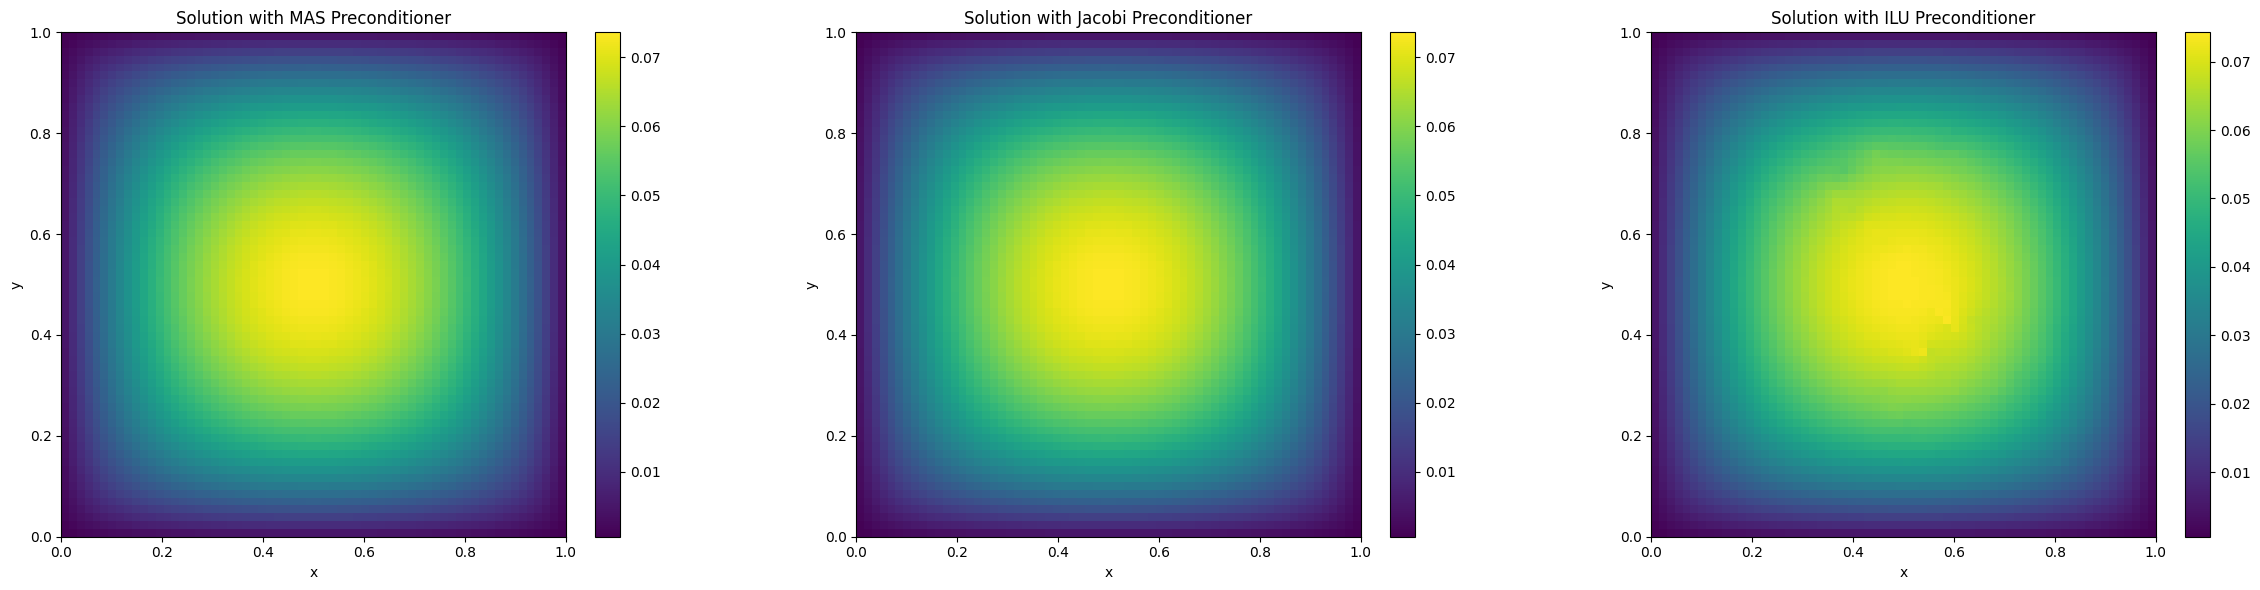

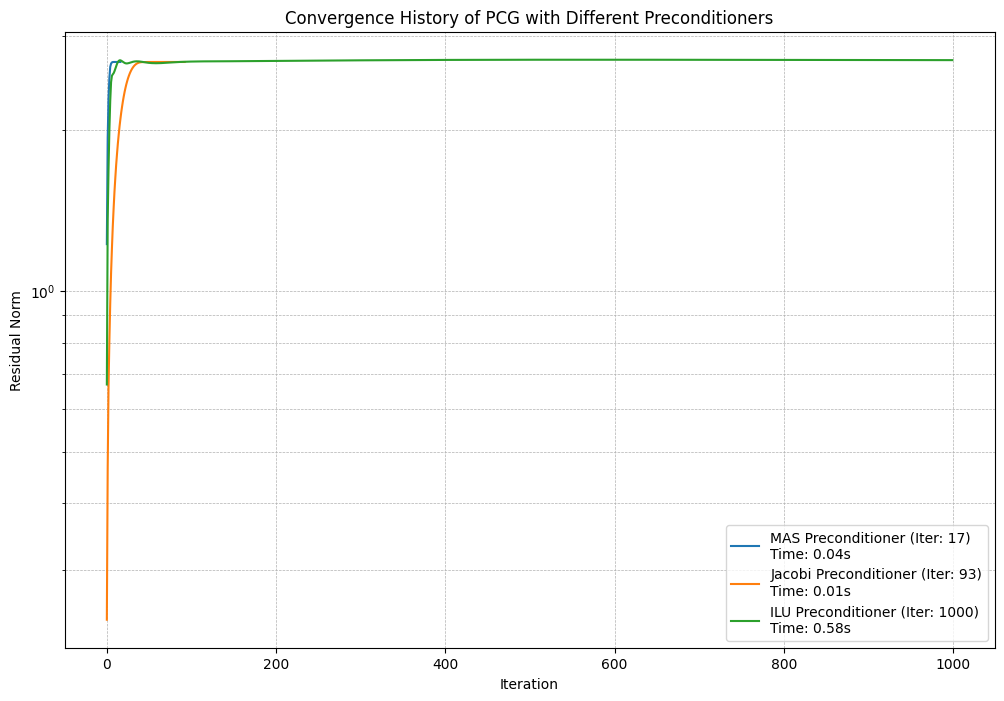


Performance Summary:
MAS Preconditioner: 17 iterations, 0.04 seconds
Jacobi Preconditioner: 93 iterations, 0.01 seconds
ILU Preconditioner: 1000 iterations, 0.58 seconds


In [9]:
if __name__ == "__main__":
    main_comparison()
